In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib notebook

# https://stackoverflow.com/questions/28320247/density-plot-on-a-sphere-python

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_loglevel('critical')
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import pandas as pd
import os
import pickle
import sys
import chart_studio.plotly as py
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
import scipy

from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table

from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage

sys.path.append('../fibermetric/')
import sta_validate
import histology
import apsym_kmeans

In [47]:
# error_key = 'error'
error_key = 'mean_err'

# make figures for 2D experiments

## Experiment 1: 2D single orienation

In [45]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
sta_out = '../outputs/sta_validate_outputs/sta_2d-96_out_v7/'
# sta_out = '../outputs/sta_validate_outputs/sta_2d_BF_out/'
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='.'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
print(errors_df.iloc[0])
errors_df.iloc[0]

2400
[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
derivative_sigma                  0.15
tensor_sigma                       0.0
AI                                 8.0
period                            13.0
width                              1.0
angles              0.2221328138901874
mean_err                       0.57424
std                                0.0
median_err                     0.57424
MAD                                0.0
Name: 0, dtype: object


derivative_sigma                  0.15
tensor_sigma                       0.0
AI                                 8.0
period                            13.0
width                              1.0
angles              0.2221328138901874
mean_err                       0.57424
std                                0.0
median_err                     0.57424
MAD                                0.0
Name: 0, dtype: object

## Figure 1: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [48]:
print(len(errors_df))
errors_df = errors_df[errors_df['period']!=7]
print(len(errors_df))
# average errors_df over all angles and periods
if error_key == 'error':
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])[error_key].median().reset_index()
else:
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['mean_err'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped[error_key].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

240000
160000


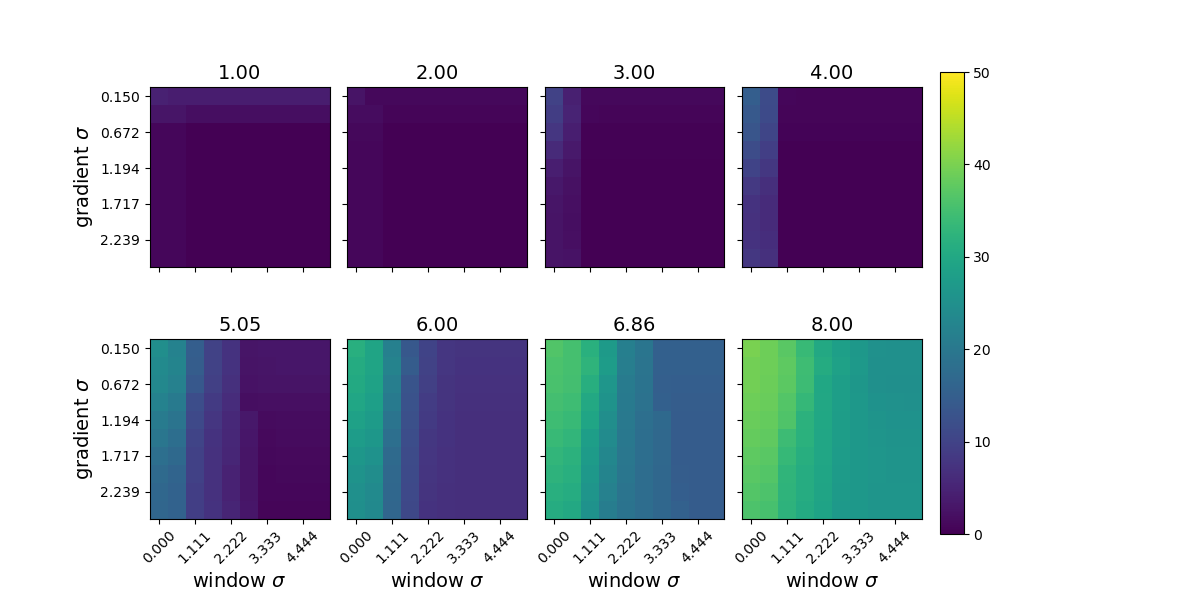

In [49]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'{AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel(r'gradient $\sigma$')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel(r'window $\sigma$')
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right', pad=0.02)
# fig.suptitle('2D Single Angle')

# fig.savefig('../outputs/sta_validate_outputs/figures/heatmaps_2d_BF_single_angle.png')

## figure 2: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [50]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
errors_max = np.max(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')


In [51]:
errors_min

array([6.12955702e-03, 1.10393322e-02, 5.24924896e-02, 8.26874770e-02,
       5.89651102e-01, 6.73682622e+00, 1.44647106e+01, 2.49729685e+01])

## figure 3: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [52]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

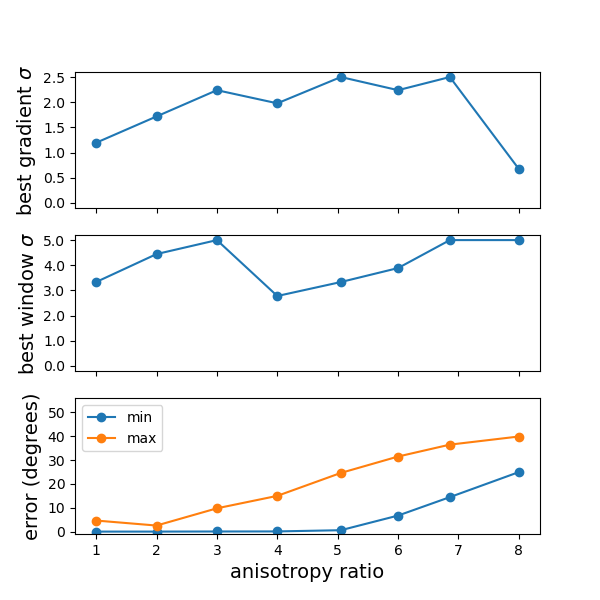

In [53]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,3.0,0.5))
axs[0].set_ylabel(r'best gradient $\sigma$')
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
yticklabels = [f'{y:.1f}'for y in np.arange(0.0,6.0,1.0)]
axs[1].set_yticks(np.arange(0.0,6.0,1.0))
axs[1].set_yticklabels(yticklabels)
axs[1].set_ylabel(r'best window $\sigma$')
axs[2].plot(AI, errors_min, marker='o')
axs[2].plot(AI, errors_max, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,55,10))
axs[2].set_ylabel('error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
axs[2].legend(['min', 'max'])
# fig.suptitle('2D Two Angles')

# fig.savefig('../outputs/sta_validate_outputs/figures/2d_BF_single_angle_lines.png')

## Experiment 2: 2D two angles

In [54]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())
print(len(files))

2400


In [55]:
# average errors_df over all angles and periods
if error_key == 'error':
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])[error_key].median().reset_index()
else:
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['mean_err'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped[error_key].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

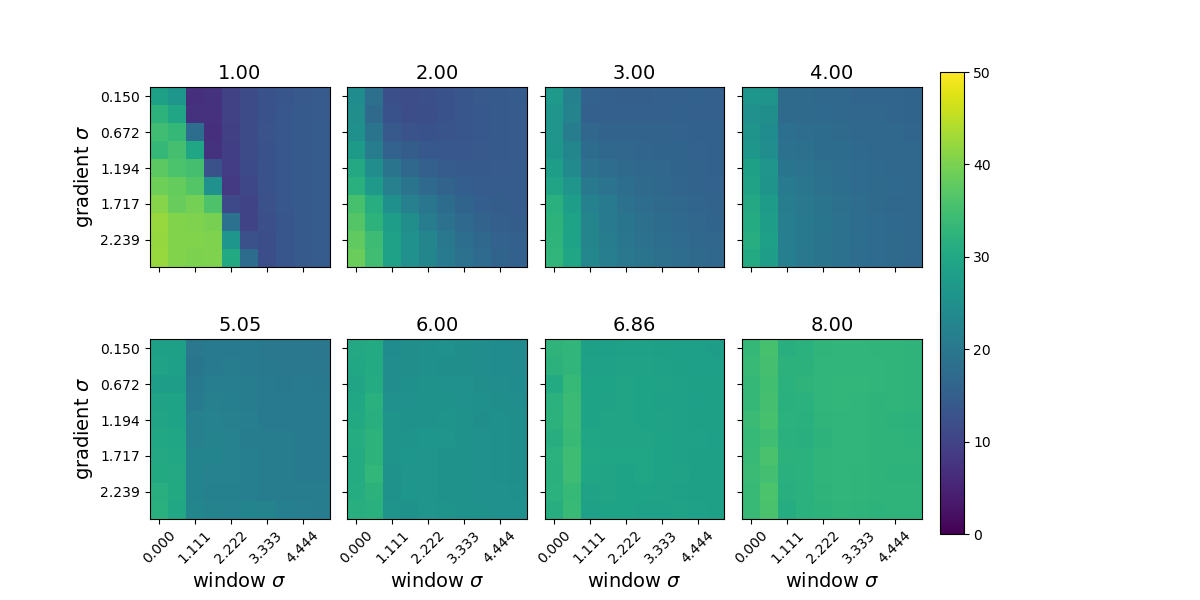

In [56]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'{AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel(r'gradient $\sigma$')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel(r'window $\sigma$')
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right', pad=0.02)

# fig.savefig('../outputs/sta_validate_outputs/figures/heatmaps_2d_BF_two_angles.png')

In [57]:
print(derivative_sigmas)
print(tensor_sigmas)

[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


In [58]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
errors_max = np.max(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

In [59]:
errors_min

array([ 6.64084539, 11.78990444, 15.1288384 , 16.12137288, 19.45308432,
       24.09478558, 28.0647164 , 31.01663844])

In [60]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
# fig, axs = plt.subplots(2, sharex=True)
# axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
# axs[0].set_ylim(-0.1,2.6)
# axs[0].set_yticks(np.arange(0.0,2.75,0.25))
# axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
# axs[1].set_ylim(-0.2,5.2)
# axs[1].set_yticks(np.arange(0.0,5.5,0.5))
# axs[0].set_ylabel('best gradient sigma')
# axs[1].set_ylabel('best window sigma')
# axs[1].set_xlabel('anisotropy ratio')

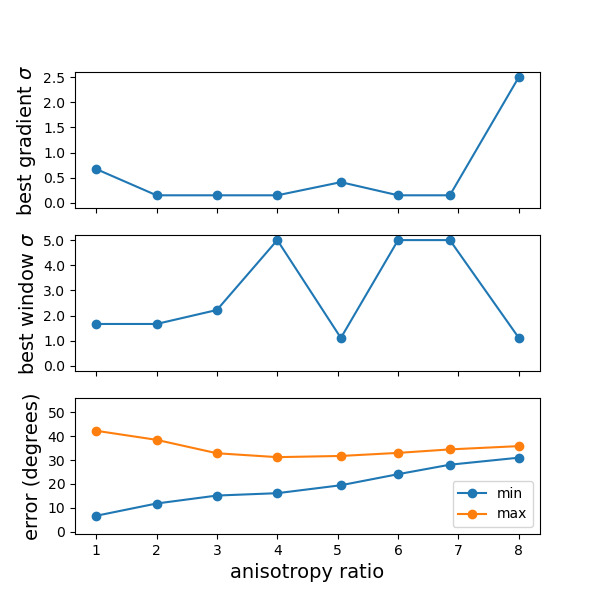

In [61]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,3.0,0.5))
axs[0].set_ylabel(r'best gradient $\sigma$')
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
yticklabels = [f'{y:.1f}'for y in np.arange(0.0,6.0,1.0)]
axs[1].set_yticks(np.arange(0.0,6.0,1.0))
axs[1].set_yticklabels(yticklabels)
axs[1].set_ylabel(r'best window $\sigma$')
axs[2].plot(AI, errors_min, marker='o')
axs[2].plot(AI, errors_max, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,55,10))
axs[2].set_ylabel('error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
axs[2].legend(['min', 'max'])
# fig.suptitle('2D Two Angles')

# fig.savefig('../outputs/sta_validate_outputs/figures/2d_BF_two_angles_lines.png')

# 3D experiments

## Experiment 4: single orientation

In [62]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v7/'
# sta_out = '../outputs/sta_validate_outputs/sta_3d_iso-blur_out_v7/'
# sta_out = '../outputs/sta_validate_outputs/sta_3d_BF_out/'

files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='_'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
errors_df.iloc[0]

2400
[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


derivative_sigma                                       0.15
tensor_sigma                                            0.0
AI                                                      8.0
period                                                 10.0
width                                                   1.0
angles              [1.1112644169182018, 3.090722384277176]
mean_err                                          88.445385
std                                                     0.0
median_err                                        88.445385
MAD                                                     0.0
Name: 0, dtype: object

## figure 7: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [63]:
# average errors_df over all angles and periods
if error_key == 'error':
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])[error_key].median().reset_index()
else:
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['mean_err'].mean().reset_index()
errors_df_grouped.iloc[79:85]

,derivative_sigma,tensor_sigma,AI,mean_err
79,0.150000,5.0,8.000000,19.564545
80,0.411111,0.0,1.000000,23.459850
81,0.411111,0.0,2.000000,27.166319
82,0.411111,0.0,3.000000,30.334151
83,0.411111,0.0,4.000000,34.299009
84,0.411111,0.0,5.142857,37.043002


In [64]:
errors = errors_df_grouped[error_key].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

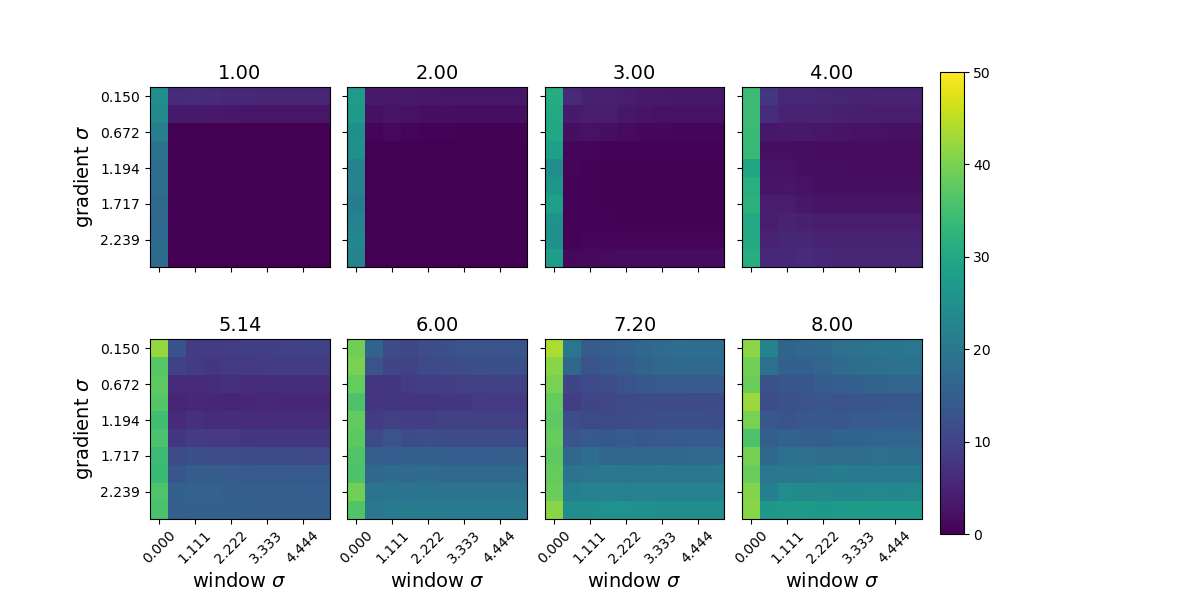

In [65]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'{AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel(r'gradient $\sigma$')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel(r'window $\sigma$')
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right', pad=0.02)

## figure 8: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [66]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
errors_max = np.max(errors[:,1:], axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

In [67]:
print(errors_min)

[1.37340299e-02 1.04640065e-02 1.97150591e-01 1.64456871e+00
 5.20115340e+00 7.46440541e+00 9.17194451e+00 1.18559018e+01]


## figure 9: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [68]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

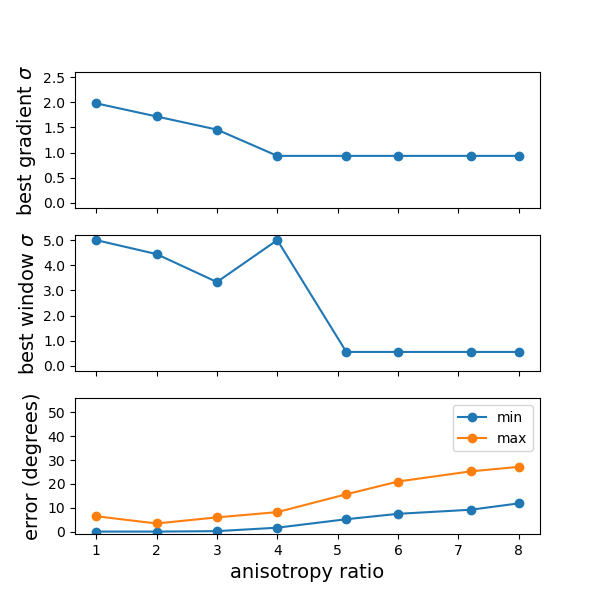

In [69]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,3.0,0.5))
axs[0].set_ylabel(r'best gradient $\sigma$')
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
yticklabels = [f'{y:.1f}'for y in np.arange(0.0,6.0,1.0)]
axs[1].set_yticks(np.arange(0.0,6.0,1.0))
axs[1].set_yticklabels(yticklabels)
axs[1].set_ylabel(r'best window $\sigma$')
axs[2].plot(AI, errors_min, marker='o')
axs[2].plot(AI, errors_max, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,55,10))
axs[2].set_ylabel('error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
axs[2].legend(['min', 'max'])

## Error vs angle

PearsonRResult(statistic=-0.1949685246464642, pvalue=0.05191106138145048)


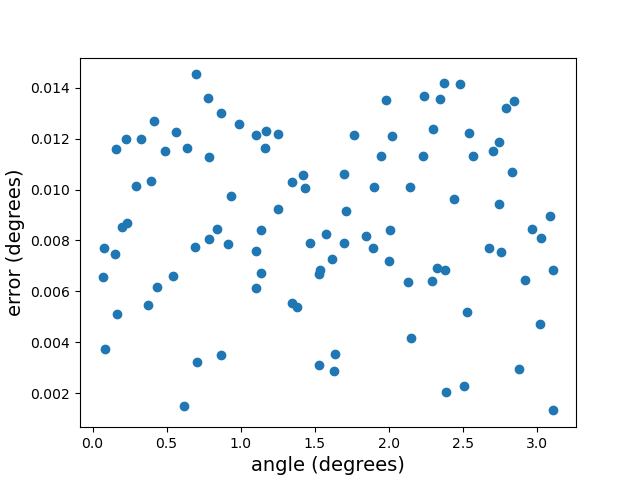

In [70]:
import scipy


df = errors_df.query(f'derivative_sigma=={derivative_sigmas[7]} and tensor_sigma=={tensor_sigmas[9]} and AI==1.0 and period==10.0')

errors = df[error_key]
angles = df['angles']
angles = np.array([np.array(a) for a in angles])
plt.figure()
plt.scatter(angles[:,1], errors)
plt.xlabel('angle (degrees)')
plt.ylabel('error (degrees)')
correlation = scipy.stats.pearsonr(angles[:,0], errors)
print(correlation)

## Experiment 5: 3D two angles

In [71]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

## figure 10: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [72]:
if error_key == 'error':
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])[error_key].median().reset_index()
else:
    errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['mean_err'].mean().reset_index()
errors = errors_df_grouped[error_key].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

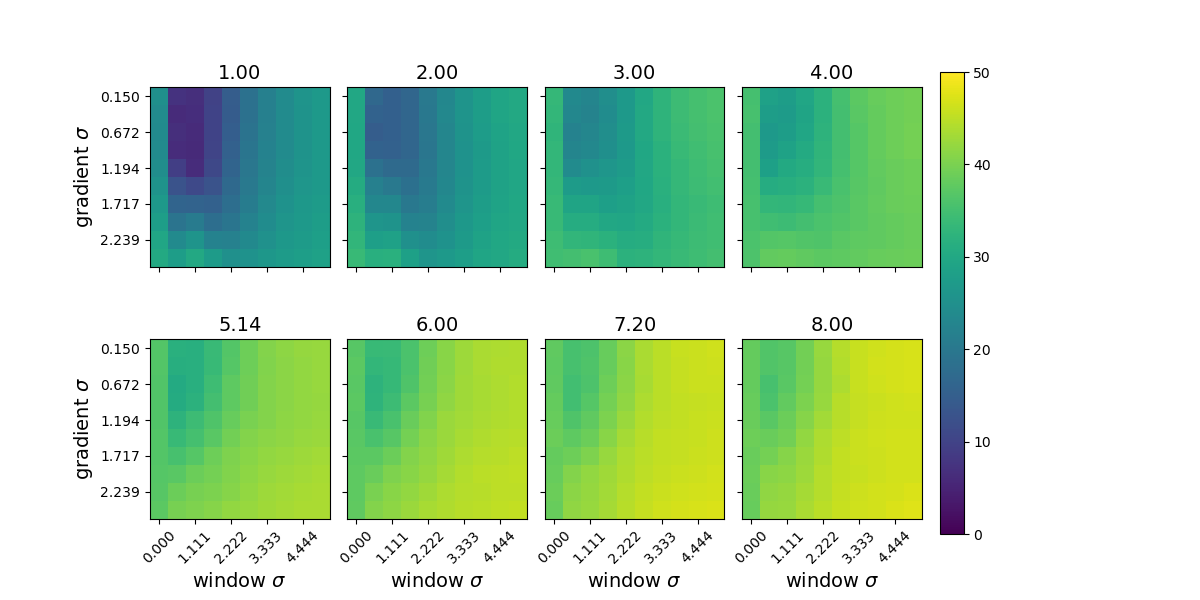

In [73]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'{AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel(r'gradient $\sigma$')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel(r'window $\sigma$')
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right', pad=0.02)


In [74]:
print(derivative_sigmas)
print(tensor_sigmas)

[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


## figure 11: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [75]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
errors_max = np.max(errors[:,1:], axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

## figure 12: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [76]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

In [77]:
print(errors_min)

[ 6.01273857 14.68726204 22.21648733 26.99228305 30.50846986 32.39841498
 34.82454887 35.46889115]


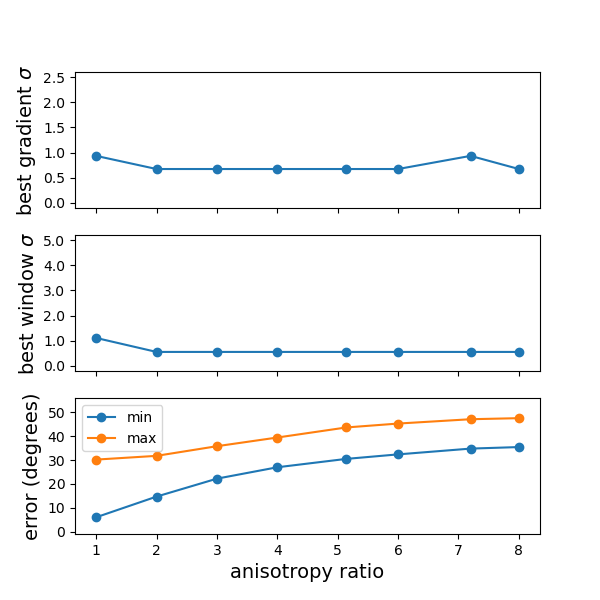

In [78]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,3.0,0.5))
axs[0].set_ylabel(r'best gradient $\sigma$')
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
yticklabels = [f'{y:.1f}'for y in np.arange(0.0,6.0,1.0)]
axs[1].set_yticks(np.arange(0.0,6.0,1.0))
axs[1].set_yticklabels(yticklabels)
axs[1].set_ylabel(r'best window $\sigma$')
axs[2].plot(AI, errors_min, marker='o')
axs[2].plot(AI, errors_max, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,55,10))
axs[2].set_ylabel('error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
axs[2].legend(['min', 'max'])

## How does delta angle affect error?

Text(0, 0.5, 'count')

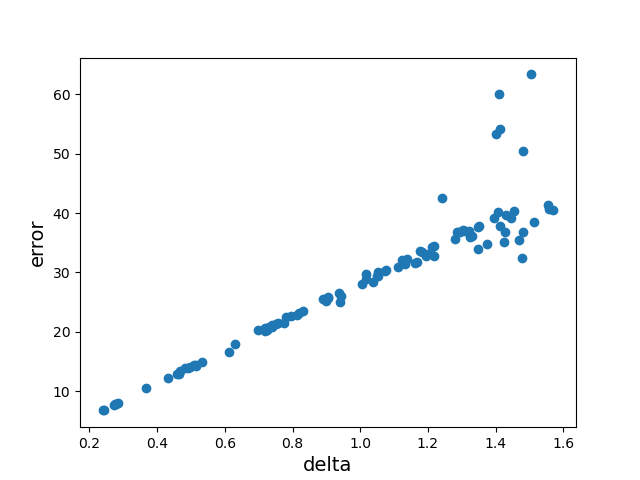

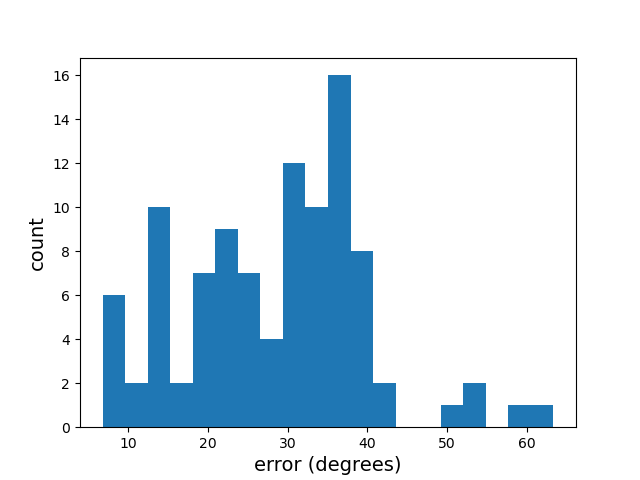

In [79]:
df = errors_df.query(f'derivative_sigma=={derivative_sigmas[7]} and tensor_sigma=={tensor_sigmas[9]} and AI==1.0 and period==10.0')

errors = df[error_key]
angles = df['angles']
delta = np.empty(len(angles))
mean = np.empty((len(angles), 2))
for i,a in enumerate(angles):
    u = np.array([np.sin(a[0][0])*np.sin(a[0][1]), np.sin(a[0][0])*np.cos(a[0][1]), np.cos(a[0][0])])
    v = np.array([np.sin(a[1][0])*np.sin(a[1][1]), np.sin(a[1][0])*np.cos(a[1][1]), np.cos(a[1][0])])
    dp = np.dot(u,v)
    delta[i] = np.arccos(np.abs(dp))
    sign = np.sign(dp)
    m = np.mean((sign*u,v), axis=0)
    m = m / np.linalg.norm(m)
    mean[i] = np.array([np.arccos(m[2]), np.arctan2(m[0], m[1])])

# scatter plot of errors by delta
plt.figure()
plt.scatter(delta, errors)
plt.xlabel('delta')
plt.ylabel('error')

# histogram of errors
plt.figure()
plt.hist(errors, bins=20)
plt.xlabel('error (degrees)')
plt.ylabel('count')



In [80]:
print(df.iloc[np.argmax(df[error_key])]['angles'])
print(df.iloc[np.argmax(df[error_key])])
print(derivative_sigmas[4])
print(tensor_sigmas[2])



[[1.07090432 2.54334684]
 [1.94093602 1.10223579]]
derivative_sigma                                             1.977778
tensor_sigma                                                      5.0
AI                                                                1.0
period                                                           10.0
width                                                             1.0
angles              [[1.0709043226400712, 2.5433468356471285], [1....
mean_err                                                    63.364446
std                                                               0.0
median_err                                                  63.364446
MAD                                                               0.0
Name: 79, dtype: object
1.1944444444444444
1.1111111111111112


# blur vs no blur Boxplot

In [81]:
def tuplizer(x):
    return tuple(x.flatten()) if isinstance(x, (np.ndarray, list)) else x

# load 2D unblurred data
sta_out = '../outputs/sta_validate_outputs/sta_2d-96_out_v7/'
files = os.listdir(sta_out)
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)

errors_2d_min = errors_df.applymap(tuplizer)
errors_2d_min = errors_2d_min.groupby(['AI', 'period', 'angles'])[error_key].min().reset_index()
errors_2d_min = list(errors_2d_min['median_err'])

# load 2d blurred data
sta_out = '../outputs/sta_validate_outputs/sta_2d_iso-blur_out_v7/'
files = os.listdir(sta_out)
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)

errors_2d_min_blur = errors_df.applymap(tuplizer)
errors_2d_min_blur = errors_2d_min_blur.groupby(['AI', 'period', 'angles'])[error_key].min().reset_index()
errors_2d_min_blur = list(errors_2d_min_blur['median_err'])

# load 3D unblurred data
sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v7/'
files = os.listdir(sta_out)
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)

errors_3d_min = errors_df.applymap(tuplizer)
errors_3d_min = errors_3d_min.groupby(['AI', 'period', 'angles'])[error_key].min().reset_index()
errors_3d_min = list(errors_3d_min['median_err'])

# load 3D blurred data
sta_out = '../outputs/sta_validate_outputs/sta_3d_iso-blur_out_v7/'
files = os.listdir(sta_out)
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)

errors_3d_min_blur = errors_df.applymap(tuplizer)
errors_3d_min_blur = errors_3d_min_blur.groupby(['AI', 'period', 'angles'])[error_key].min().reset_index()
errors_3d_min_blur = list(errors_3d_min_blur['median_err'])



KeyError: 'median_err'

NameError: name 'errors_2d_min_blur' is not defined

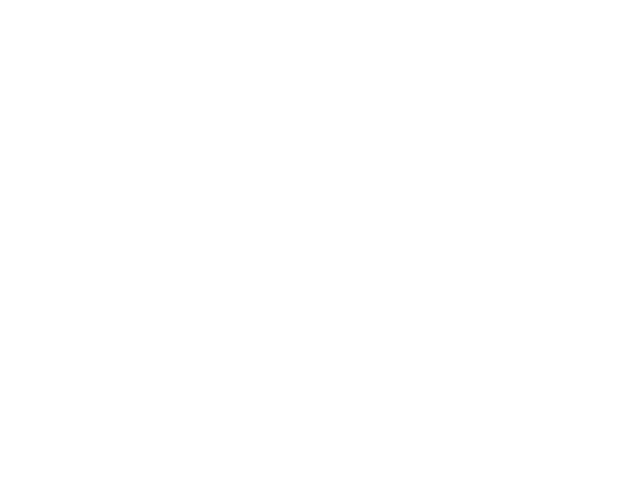

In [82]:
# box and whisker plot without outliers
plt.figure()
plt.boxplot([errors_2d_min, errors_2d_min_blur, errors_3d_min, errors_3d_min_blur], showfliers=False)
plt.xticks([1,2,3,4], ['2D', '2D with Blur', '3D', '3D with Blur'])
plt.ylabel('error (degrees)')


# Pipeline Figures

# first we generate a phantom with specified line orienations, period, and anisotropy  

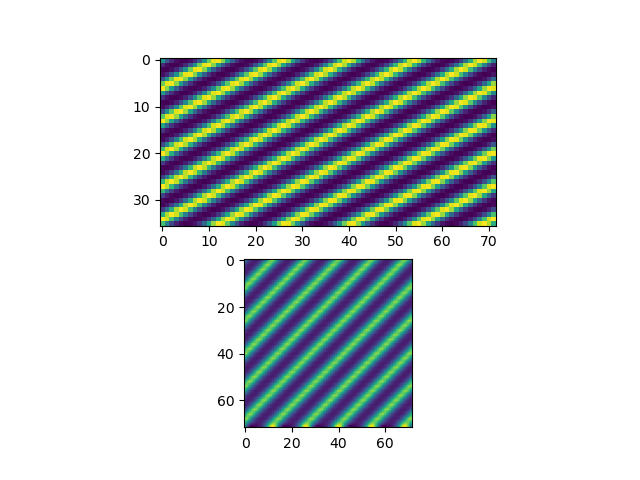

In [5]:
# in 2D
n = (36, 72)
d = (2.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([3*np.pi/4])
img = sta_validate.make_phantom(x, angles, interp=False)
img_upsampled = sta_validate.make_phantom(x, angles)

fig, axs = plt.subplots(2)
axs[0].imshow(img)
axs[1].imshow(img_upsampled)

True

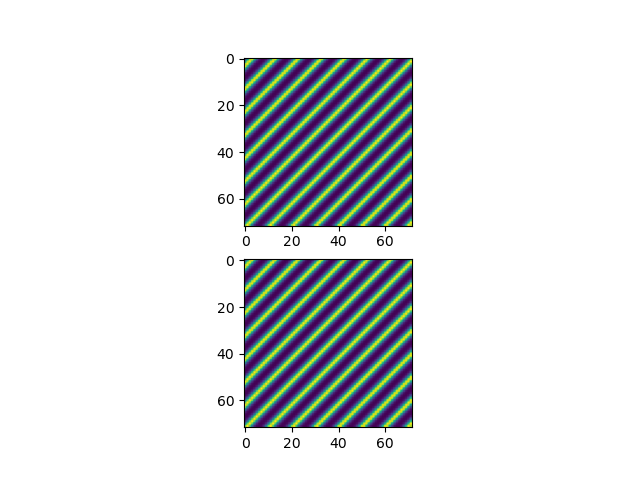

In [85]:
# in 2D
n = (72, 72)
d = (1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([3*np.pi/4])
img = sta_validate.make_phantom(x, angles, period=7.0)
sigma = 2.0
img_blur = gaussian_filter(img, sigma=0.0)
# img_blur5 = gaussian_filter(gaussian_filter(gaussian_filter(gaussian_filter(img_blur, sigma), sigma), sigma), sigma)
# img_blur5_alt = gaussian_filter(img, sigma=(4*sigma))

fig, axs = plt.subplots(2)
axs[0].imshow(img)
axs[1].imshow(img_blur)
np.allclose(img, img_blur)
# axs[1].imshow(img_blur5, vmin=0.0, vmax=0.15)
# axs[2].imshow(img_blur5_alt, vmin=0.0, vmax=0.15)

# start,stop = (28,46)
# axs[0].imshow(img[start:stop, start:stop])
# axs[1].imshow(img_blur5[start:stop, start:stop])
# axs[2].imshow(img_blur5_alt[start:stop, start:stop])

# print(np.sum(np.abs(img_blur5[start:stop, start:stop]-img_blur5_alt[start:stop, start:stop]))/np.mean(img_blur5[start:stop, start:stop]))


In [83]:
errors_df['angles'].iloc[0].shape


(2,)

In [35]:
plt.close('all')

In [84]:
print(derivative_sigmas[2])
print(tensor_sigmas[1])

0.6722222222222223
0.5555555555555556


[[1.04719755 0.        ]
 [0.         0.        ]]


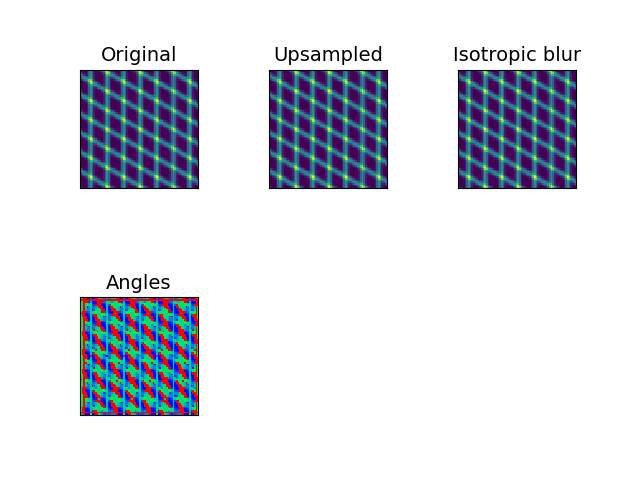

In [86]:
# in 3D
# shapes = [(72,72,72), (36,72,72), (24,72,72), (18,72,72), (14,72,72), (12,72,72), (10,72,72), (9,72,72)]
# shapes = [(72,72,72), (24,72,72), (14,72,72), (10,72,72)]
shapes = [(72,72,72)]


AI = [d[1]/d[0] for d in shapes]
period=10.0
sigma0 = derivative_sigmas[2]
sigma1 = tensor_sigmas[1]
# true_thetas = np.array([np.pi/4, 3*np.pi/4])
# true_thetas = errors_df['angles'].iloc[0]
# true_thetas = np.array([[np.pi/3, 0.0]])
true_thetas = np.array([[np.pi/3, 0.0],
                        [0.0, 0.0]])
print(true_thetas)
fig, ax = plt.subplots(2,3)
angles_dist = []
for i in range(1): #ax.shape[1]):
    n = shapes[i]
    d = (n[1]/n[0], 1.0, 1.0)
    x = [np.arange(ni)*di for ni, di in zip(n, d)]
    crop = round(max(sigma0,sigma1)*8.0/3) # two-thirds the radius of the largest kernel
    crop_end = round(AI[i]) - 1
    img = sta_validate.make_phantom(x, true_thetas, period=period, interp=False, noise=1e-12)
    img_up = sta_validate.make_phantom(x, true_thetas, period=period, noise=1e-12)
    img_blur = sta_validate.make_phantom(x, true_thetas, period=period, blur_correction=True, noise=1e-12)
    # img_up = np.random.randn(72,72,72) * 1e-6
    S = histology.structure_tensor(img_up, derivative_sigma=sigma0, tensor_sigma=sigma1, normalize=True)
    angles = histology.angles(S, cartesian=True)
    angles_dist.append(angles[crop:-crop-crop_end, crop:-crop, crop:-crop].reshape(-1,3)) # save for k-means
    # angles_ = (angles - np.min(angles)) / (np.max(angles)-np.min(angles))
    angles_ = np.abs(angles)
    crop_color = [1.0,0.0,0.0]
    angles_[crop] = crop_color
    angles_[-crop-crop_end] = crop_color
    angles_[:,crop] = crop_color
    angles_[:,-crop] = crop_color
    angles_[:,:,crop] = crop_color
    angles_[:,:,-crop] = crop_color
    extent = (x[1][0]-d[1]/2, x[1][-1]+d[1]/2, x[0][-1]+d[0]/2, x[0][0]-d[0]/2)

    # ax[0][i].imshow(img[:,:,36], extent=extent, interpolation='none')
    # ax[0][i].set_title(f'AI = {d[0]:.2f}')
    # ax[1][i].imshow(img_up[:,:,36], extent=extent, vmin=1e-6, interpolation='none')
    # ax[2][i].imshow(img_blur[:,:,36], extent=extent, interpolation='none')
    # ax[3][i].imshow(angles_[:,:,36], extent=extent, interpolation='none')

    # ax[0].imshow(img[:,:,36], extent=extent, interpolation='none')#, vmin=1e-3)
    # ax[0].set_title(f'Original')
    # ax[1].imshow(img_up[:,:,36], extent=extent, interpolation='none')#, vmin=2e-2)
    # ax[1].set_title('Upsampled')
    # ax[2].imshow(img_blur[:,:,36], extent=extent, interpolation='none')#, vmin=2e-2)
    # ax[2].set_title('Isotropic blur')
    # ax[3].imshow(angles_[:,:,36], extent=extent, interpolation='none')
    # ax[3].set_title('Angles')

    ax[0][0].imshow(img[:,:,36], extent=extent, interpolation='none')#, vmin=1e-3)
    ax[0][0].set_title('Original')
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][1].imshow(img_up[:,:,36], extent=extent, interpolation='none')#, vmin=2e-2)
    ax[0][1].set_title('Upsampled')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][2].imshow(img_blur[:,:,36], extent=extent, interpolation='none')#, vmin=2e-2)
    ax[0][2].set_title('Isotropic blur')
    ax[0][2].set_xticks([])
    ax[0][2].set_yticks([])
    ax[1][0].imshow(angles_[:,:,36], extent=extent, interpolation='none')
    ax[1][0].set_title('Angles')
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][1].set_axis_off()
    ax[1][2].set_axis_off()

    plt.subplots_adjust(hspace=0.6, wspace=0.6)#, hspace=0.5)

In [3]:
skm = apsym_kmeans.APSymKMeans(n_clusters=2)

mu_list = []
for i in range(len(angles_dist)):
    skm.fit(angles_dist[i])
    mu_list.append(skm.cluster_centers_)

NameError: name 'angles_dist' is not defined

In [79]:
skm = apsym_kmeans.APSymKMeans(n_clusters=2)
angles_ = angles[crop:-crop-crop_end, crop:-crop, crop:-crop].reshape(-1,3)
skm.fit(angles_)
mu = skm.cluster_centers_
mu

array([[-0.0012775 , -0.05353114, -0.99856536],
       [-0.87047911,  0.49146632, -0.02696244]])

In [10]:
# helper functions for visualization
WINDOW_SIZE = (900, 900)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30, mu=None, true_thetas=None):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm, )#, radial_scale=scale)
    scene.add(sf_actor)

    is_mu = mu is not None
    is_true_thetas = true_thetas is not None

    if is_mu:
        mu_lines = np.array([[mu[0],-mu[0]],
                        [mu[1],-mu[1]]]) / 1.5
        mu_colors = np.array([[0,1,0],
                        [0,1,0]])
        lines = mu_lines
        colors = mu_colors

    if is_true_thetas:
        x_cart = np.array([np.sin(true_thetas[:,1])*np.sin(true_thetas[:,0]),
                           np.cos(true_thetas[:,1])*np.sin(true_thetas[:,0]),
                           np.cos(true_thetas[:,0])]).T
        
        true_lines = np.array([[x_cart[0],-x_cart[0]],
                        [x_cart[1],-x_cart[1]]]) / 1.5
        true_colors = np.array([[0.6,0.2,0.95],
                        [0.6,0.2,0.95]])
        lines = true_lines
        colors = true_colors

    if is_mu and is_true_thetas:
            lines = np.concatenate((mu_lines, true_lines), axis=0)
            colors = np.concatenate((mu_colors, true_colors), axis=0)
    
    if is_mu or is_true_thetas:
        lines_actor = actor.line(lines, colors=colors, linewidth=3)
        scene.add(lines_actor)
        if rot:
            lines_actor.RotateX(90)
            lines_actor.RotateZ(270)
            # lines_actor.RotateY(90)

    if rot:
        sf_actor.RotateX(90)
        sf_actor.RotateZ(270)
        # sf_actor.RotateY(90)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
        sf_actor.RotateZ(theta_step)
        if mu is not None:
            lines_actor.RotateZ(theta_step)

        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 20000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile
        

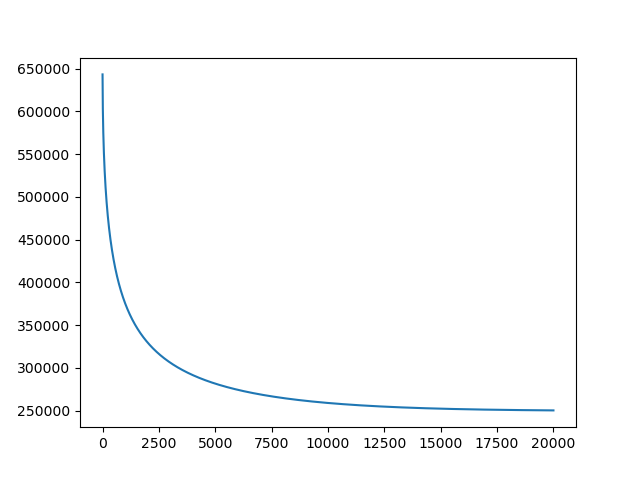

In [8]:
n_pts = 256
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial,20000, const=0.4)

vertices = hsph_updated.vertices
# values = np.ones(vertices.shape[0])
# bvecs = np.vstack((vertices))
# bvals = np.hstack((bvalue * values))
# # add some b=0 bvals/bvecs
# bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
# bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

# gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

plt.figure()
plt.plot(potential)

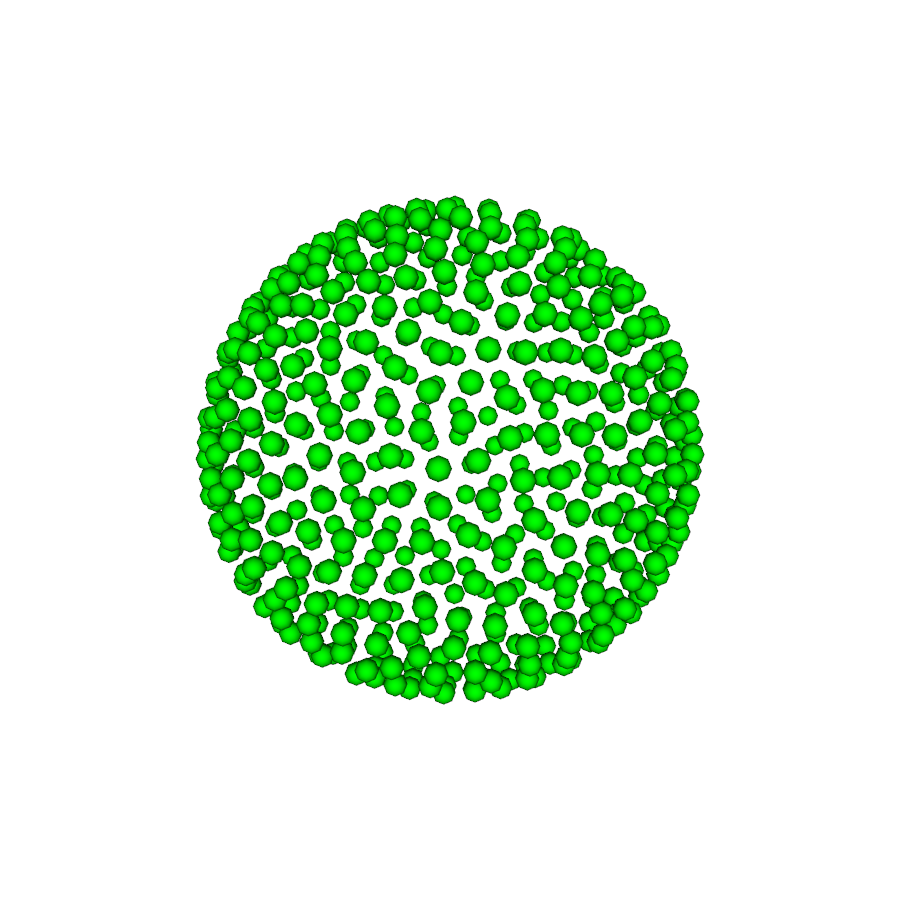

In [11]:
image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

In [ ]:
angles_dist = []

In [12]:
# count the number of angles closest to each vertex
hist_sph_list = []
for i in range(len(angles_dist)):
    ids = np.argmax(np.abs(angles_dist[i] @ vertices.T), axis=1)
    unique, counts = np.unique(ids, return_counts=True)
    hist = np.zeros(vertices.shape[0])
    hist[unique] = counts
    hist_sph = np.zeros(vertices.shape[0]*2)
    hist_sph[:vertices.shape[0]] = hist
    hist_sph[vertices.shape[0]:] = hist
    hist_sph_list.append(hist_sph)

NameError: name 'angles_dist' is not defined

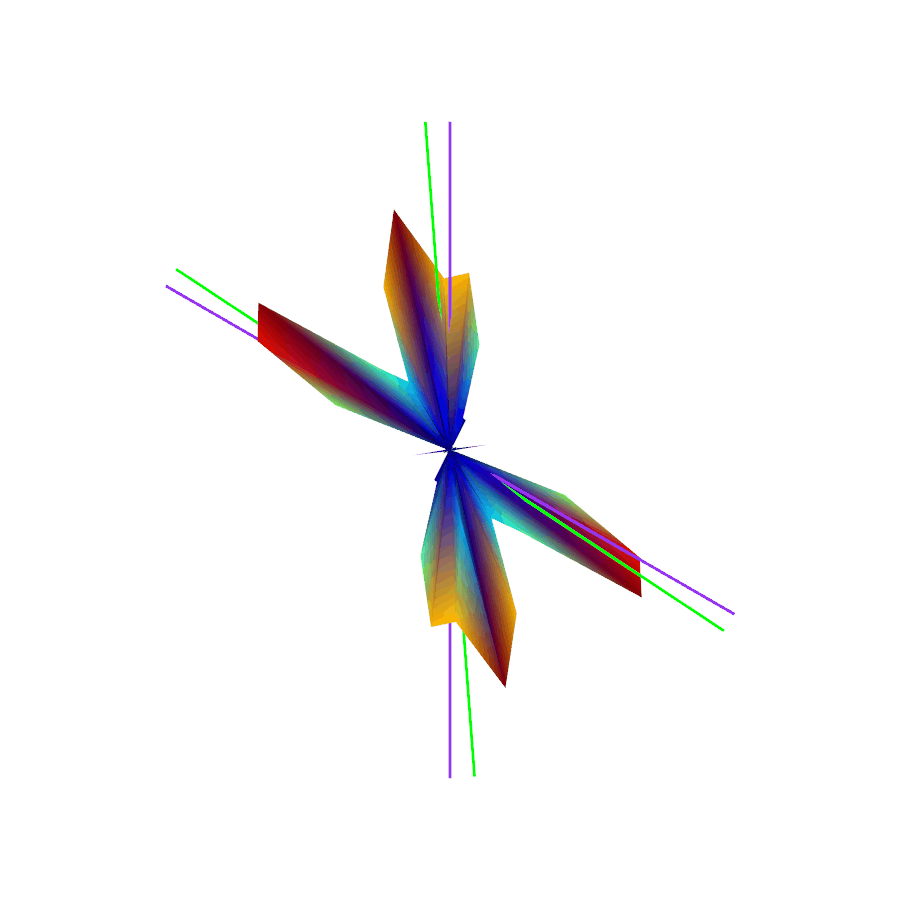

In [110]:
image = screenshot_animated_sf(hist_sph_list[0], sph_gtab, title='Histogram of STA angles', theta_step=360, rot=True, mu=mu_list[0], true_thetas=true_thetas)
Image(filename=image)

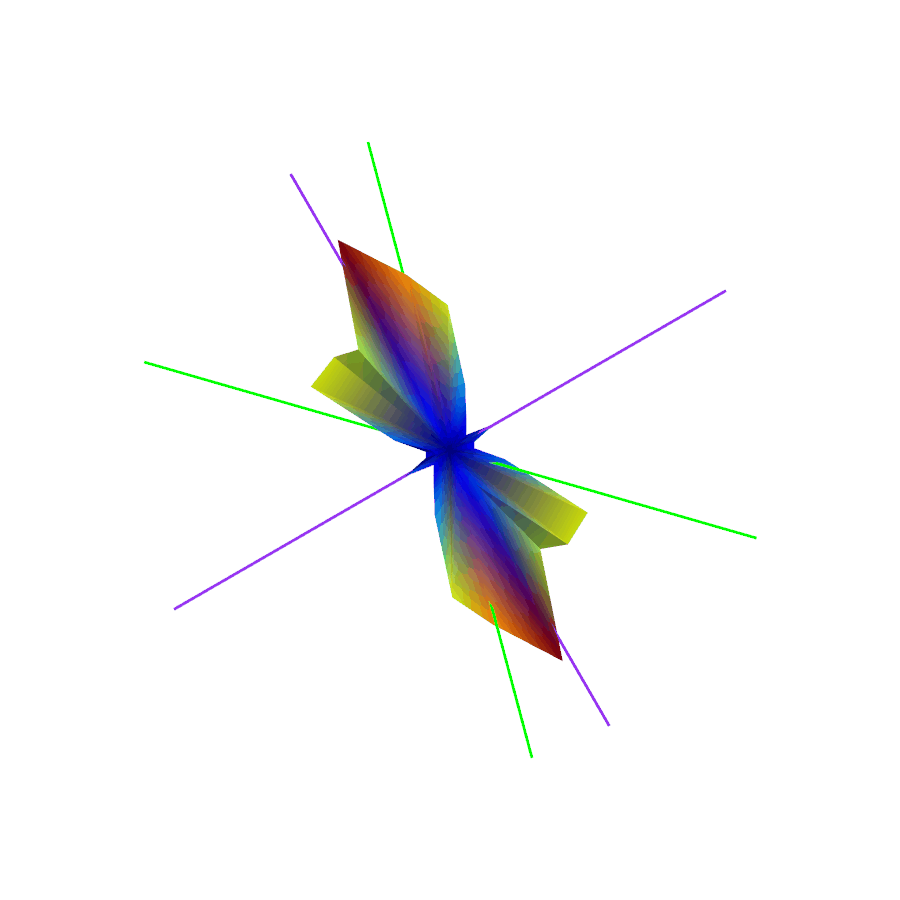

In [47]:
image = screenshot_animated_sf(hist_sph_list[1], sph_gtab, title='Histogram of STA angles', theta_step=360, rot=True, mu=mu_list[1], true_thetas=true_thetas)
Image(filename=image)

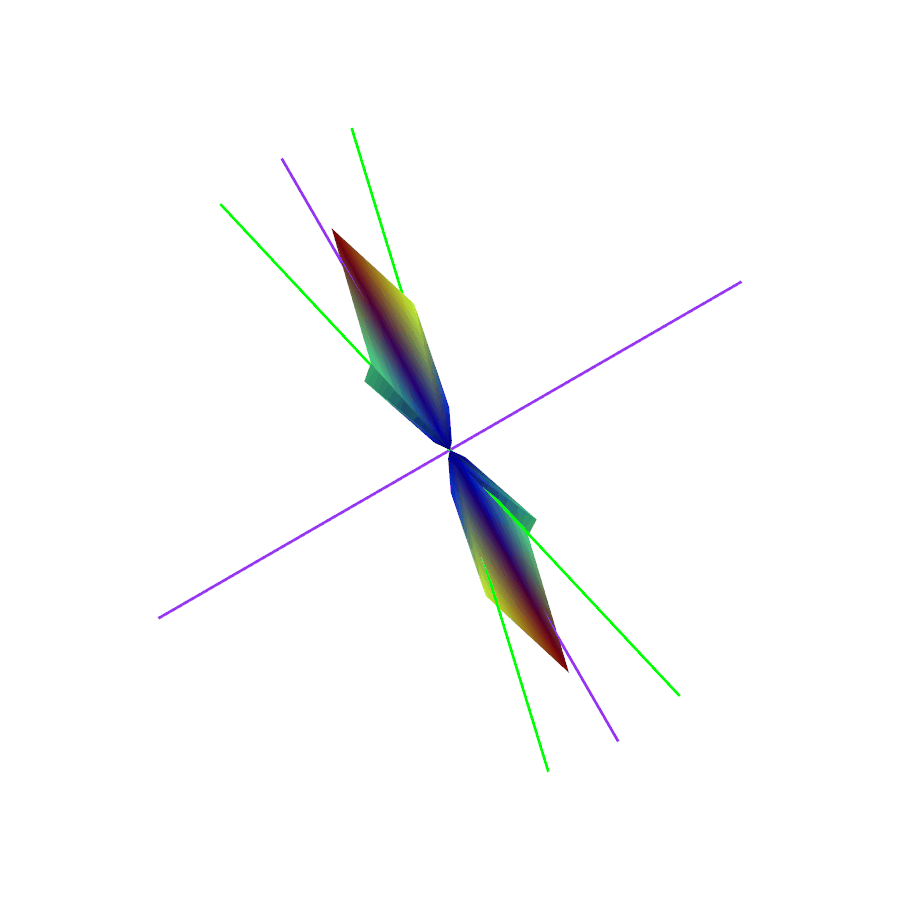

In [48]:
image = screenshot_animated_sf(hist_sph_list[2], sph_gtab, title='Histogram of STA angles', theta_step=360, rot=True, mu=mu_list[2], true_thetas=true_thetas)
Image(filename=image)

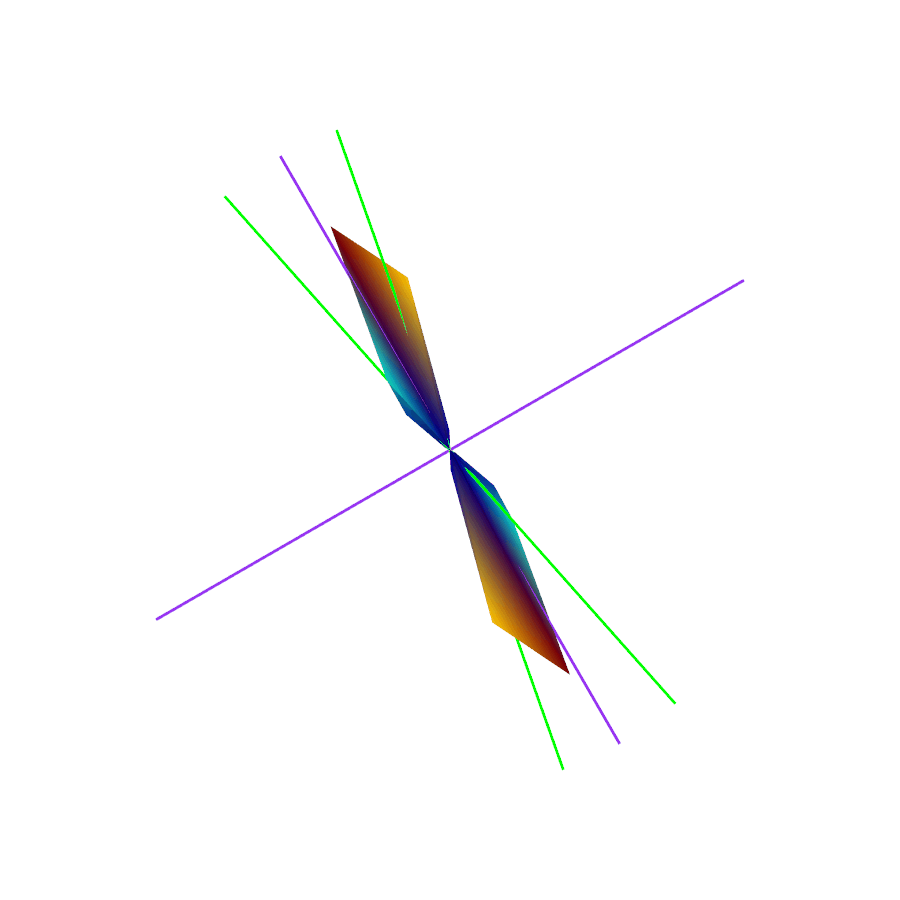

In [49]:
image = screenshot_animated_sf(hist_sph_list[3], sph_gtab, title='Histogram of STA angles', theta_step=360, rot=True, mu=mu_list[3], true_thetas=true_thetas)
Image(filename=image)

In [ ]:
# visualize with volume plot
Z,Y,X = np.mgrid[0:72:1,0:72:1,0:72:1]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=img.flatten(),
    isomin=0.04,
    isomax=0.23,
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=8, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=True,
    width=800,
    height=800,)
fig.show()
# py.iplot(fig, filename='volume_rendering')


## Next compute angles from structure tensors

In [55]:
n = (72, 72)
d = (1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([0])
img = sta_validate.make_phantom(x, angles, interp=True)
# img_upsampled = sta_validate.make_phantom(x, angles)

In [56]:
S = histology.structure_tensor(img, derivative_sigma=0.75, tensor_sigma=5.0, masked=False)
angles = histology.angles(S)
# plt.figure()
# plt.imshow(angles[:,36,:,0])#, cmap='hsv')
# plt.colorbar()

In [50]:
angles.shape

(72, 72)

In [57]:
print(np.min(angles), np.max(angles))

-0.024410538769541818 0.02116536231651908


In [ ]:
angles_ = angles.reshape((-1,angles.shape[-1]))

true_thetas_ = np.array([np.sin(true_thetas[0])*np.sin(true_thetas[1]),
                                np.sin(true_thetas[0])*np.cos(true_thetas[1]),
                                np.cos(true_thetas[0])
                                ])
skm = apsym_kmeans.APSymKMeans(n_clusters=1)
skm.fit(angles_)
mu_ = skm.cluster_centers_
# convert mu_ from cartesian to spherical coordinates
mu = np.array([np.arccos(mu_[0][2]), np.arctan2(mu_[0][0], mu_[0][1])])
diff = np.arccos(np.abs(mu_.dot(true_thetas_))) * 180/np.pi

print(mu)
print(true_thetas)

In [ ]:
print(diff)